In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

# 1 year, 6nT C_e, SV removed

In [2]:
shc_g = 30
shc_grid = 30

str_load = "Ce6_PT5M_Sy2018m11d1_Ey2019m11d1_Np100"
C_e_const = 6
samp = "PT5M"
date_start = [2018,11,1]
date_end = [2019,11,1]

file_pickle = open("{}_{}.obj".format(nb_name,str_load), 'rb')
core = pickle.load(file_pickle)
file_pickle.close()
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

# Swarm obs
import datetime as dt
from viresclient import SwarmRequest
request = SwarmRequest()
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]
use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"
request.set_collection(collect)
request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step=samp)

data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2]))
ds = data.as_xarray()
SZA_angle = 120
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0
dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

obs_sat = SDSS(comment, N_SH = shc_g)
obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.lat)
print(obs_sat.grid_N)

# chaosmagpy
N_chaos = 20
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_start = np.matmul(A_r,g_CHAOS7)

M_use = ds["B_NEC_LCS1"].values[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA"].values[:,2][idx_sort] #+ ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort]  

B_delta_SV =-ds["B_NEC"].values[:,2][idx_sort] + M_use - B_CHAOS7_start

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + M_use - B_delta_SV


[1/1] Processing:  100%|██████████|  [ Elapsed: 03:35, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (17.92MB)


4884


<IPython.core.display.Javascript object>


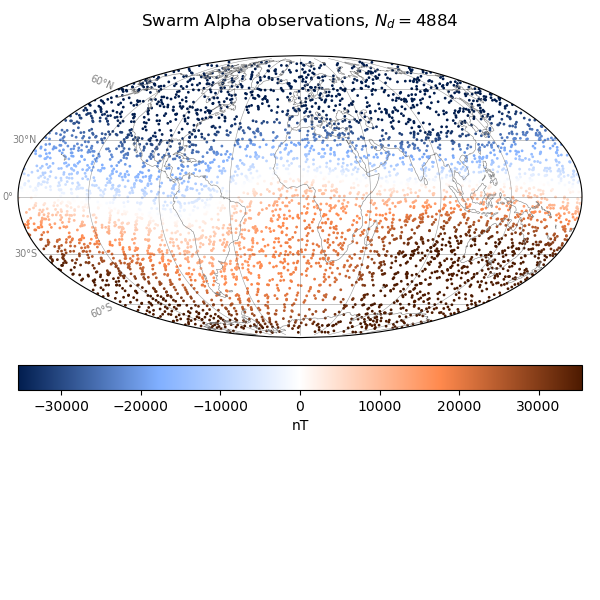

<IPython.core.display.Javascript object>


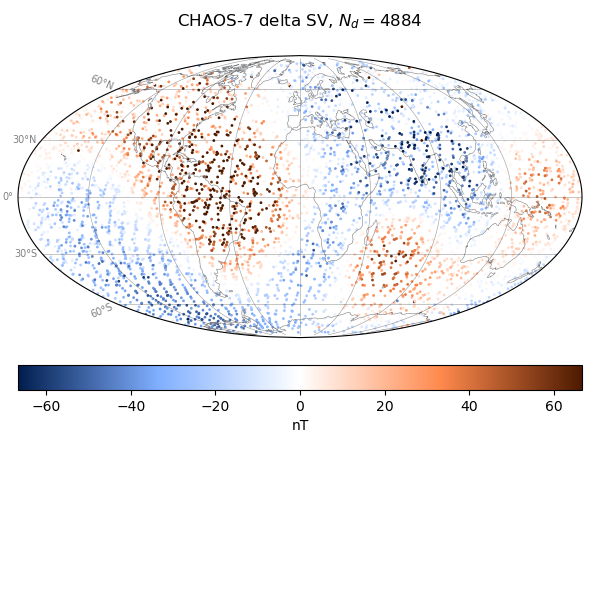

<IPython.core.display.Javascript object>


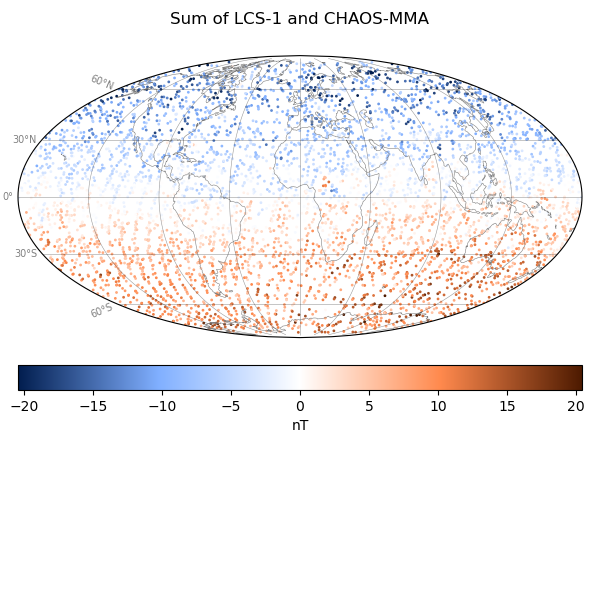

In [36]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=B_delta_SV, limits_data = [-100,100],
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 delta SV, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-M_use, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Sum of LCS-1 and CHAOS-MMA', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


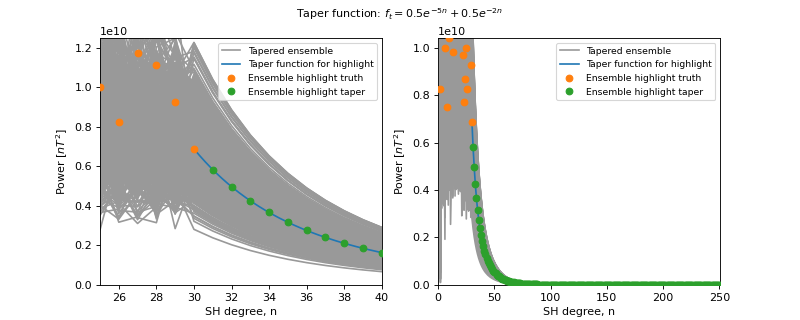

In [11]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True)

In [12]:
C_e_const = 6
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

In [13]:
core.covmod_lsq_equiv(obs_sat.data, core.C_ens_tap, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


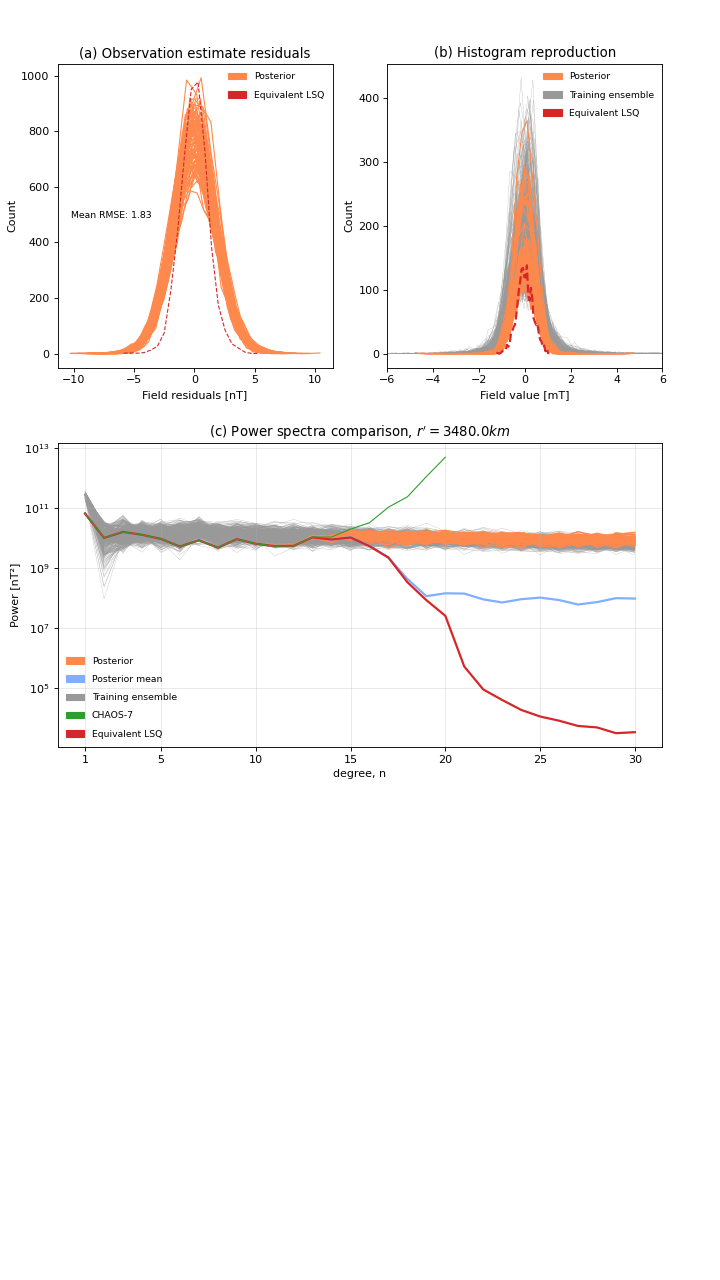

In [27]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = date_start,
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, hist_ti_ens_limit = [-6,6],
                              figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 100)

In [7]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


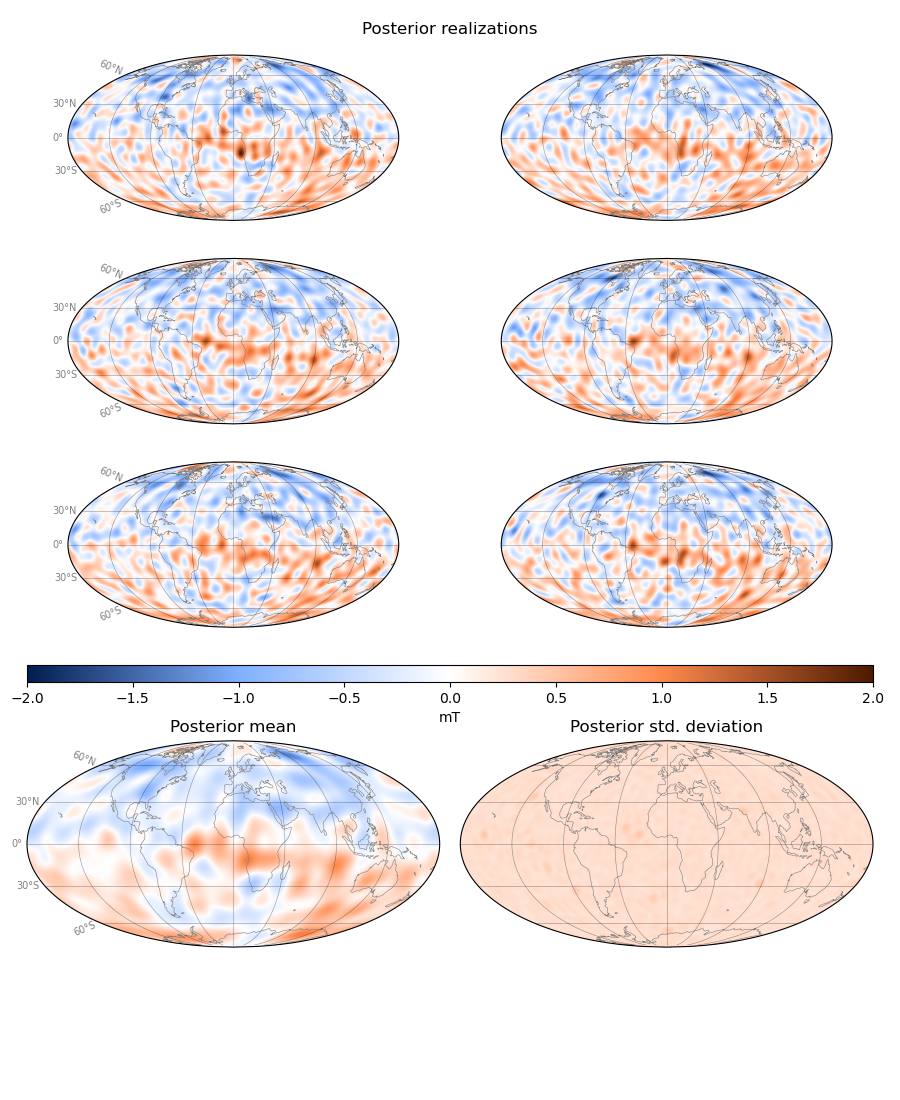

In [8]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,11), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_vires_swarm_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

In [39]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
set_nmax = 13

core.ensemble_B(core.g_spec_mean, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_equiv_lsq, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_lsq = core.B_ensemble[:,0].copy()

core.ensemble_B(g_CHAOS7, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_chaos = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


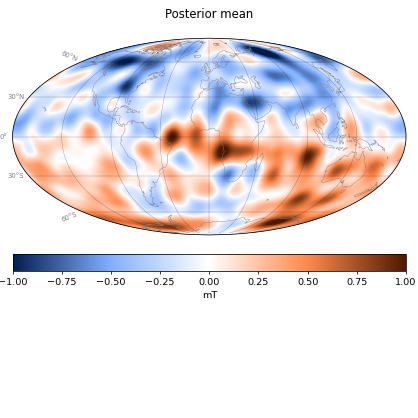

<IPython.core.display.Javascript object>


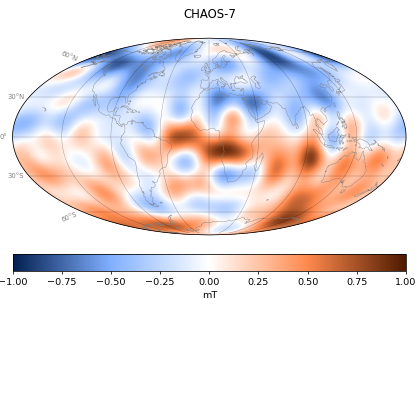

<IPython.core.display.Javascript object>


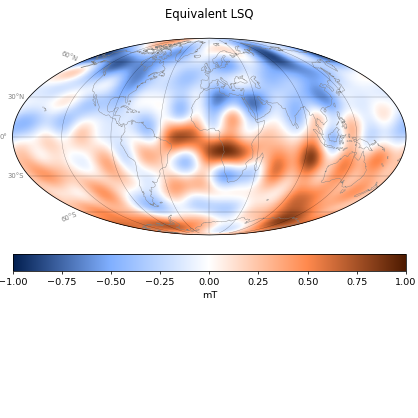

In [40]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_mean_eqa, limits_data = [-1,1],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos, limits_data = [-1,1],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_lsq, limits_data = [-1,1],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


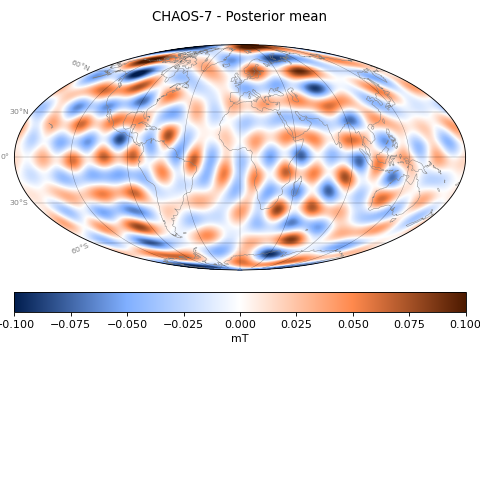

<IPython.core.display.Javascript object>


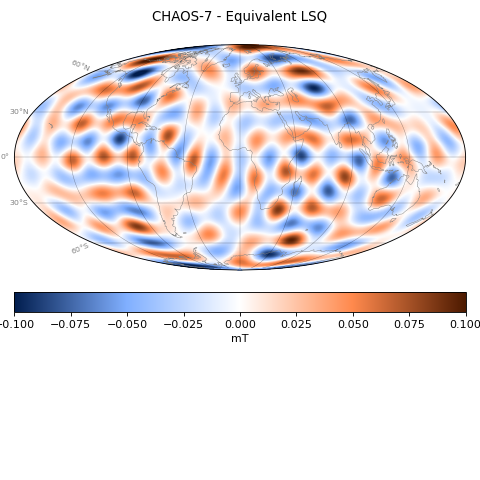

In [36]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos-zs_mean_eqa,
                cbar_h = 0.075, unit_transform_n_to_m = True, limits_data = [-0.1,0.1],
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 - Posterior mean', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos-zs_lsq,
                cbar_h = 0.075, unit_transform_n_to_m = True, limits_data = [-0.1,0.1],
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 - Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [14]:
print(core)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Swarm observations with tapered ensemble as prior
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               30
N_SH_secondary:     None
sim_type:           core_ens
grid_zero:          (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:     (31,), Max/Min: 0.10 / 0.01
grid_shape:         (2,), Max/Min: 61.00 / 31.00
grid_w:             (1891,), Max/Min: 0.10 / 0.01
grid_radial:        (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:         (1891,), Max/Min: 175.63 / 4.37
grid_phi:           (1891,), Max/Min: 354.10 / 0.00
grid_N:             1891
grid_nmax:          30
r_grid:             3480.0
grid:               (1891, 2)
sph_d:              None
lon:                (1891,), Max/Min: 354.10 / 0.00
lat:                (1891,), Max/Min: 85.63 /

In [16]:
core.g_lsq_equiv = core.g_equiv_lsq

<IPython.core.display.Javascript object>


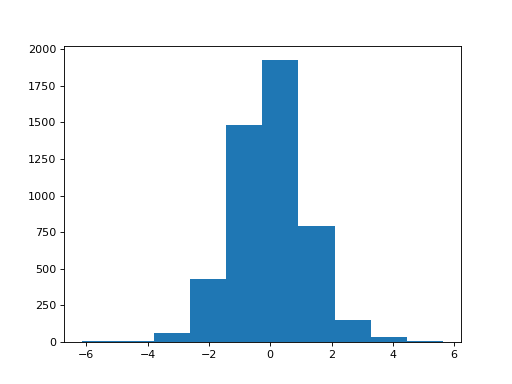

In [18]:
plt.figure()
plt.hist(core.lsq_equiv_res)
plt.show()